<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Depth_Anything_Foundation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Depth Anything
Paper: https://arxiv.org/pdf/2401.10891.pdf

In [ ]:
!pip -q install git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#Please restart the session

Original model train on the scale of 0 to 30
prediction: min scale = 4.3087287 max scale= 16.746456


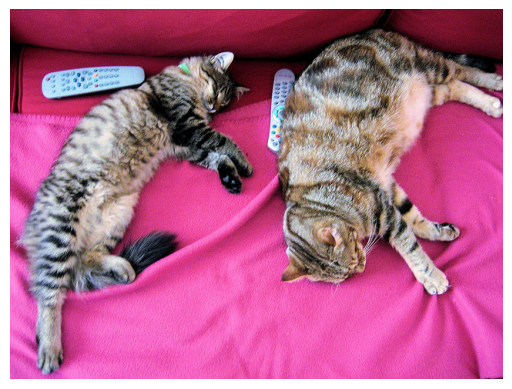

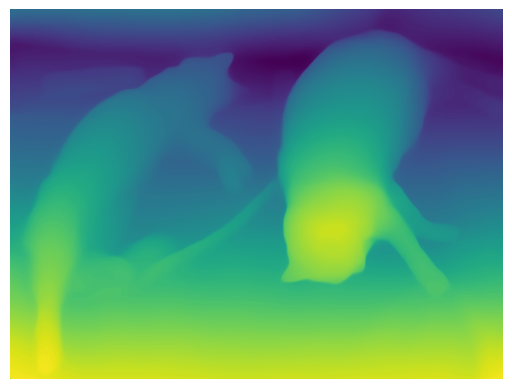

In [19]:
from transformers import DepthAnythingForDepthEstimation, AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
# model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

plt.figure(121),plt.axis('OFF'),plt.imshow(image)
plt.figure(122),plt.axis('OFF'),plt.imshow(depth);

In [21]:
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

predicted_depth.shape

torch.Size([1, 518, 686])

In [20]:
input = image_processor(images=image, return_tensors="pt")
pixel_values = input['pixel_values']
print(pixel_values.shape)
image_shape=(224,280)
pixel_values = torch.nn.functional.interpolate(pixel_values, size=image_shape, mode="bilinear", align_corners=True)
print(pixel_values.shape)
h, w = pixel_values.shape[-2:]
features = model.get_intermediate_layers(pixel_values, 4, return_class_token=True)

torch.Size([1, 3, 518, 686])
torch.Size([1, 3, 224, 280])


AttributeError: 'DepthAnythingForDepthEstimation' object has no attribute 'get_intermediate_layers'

In [7]:
import os
import torch
import torch.nn as nn

class DARES(nn.Module):
    def __init__(self,):
        super(DARES, self).__init__()
        model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

    def forward(self, pixel_values):
        return 0


In [2]:
from transformers import DepthAnythingConfig, DepthAnythingForDepthEstimation

# Initializing a DepthAnything small style configuration
configuration = DepthAnythingConfig()

# Initializing a model from the DepthAnything small style configuration
model = DepthAnythingForDepthEstimation(configuration)
# model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# Accessing the model configuration
configuration = model.config

In [4]:
model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

Liver: SCARED

In [ ]:
import gdown

d3k4_url = 'https://drive.google.com/uc?id=1_HrQTeZgU3AE88p1Ykawi2lkdijRNQVz'
gdown.download(d3k4_url,'d3k4.zip',quiet=True)
!unzip -q d3k4.zip
!mkdir liver
!mv -f d3k4 liver/

others

In [ ]:
import cv2
vidcap = cv2.VideoCapture('video.L.avi')
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read() #1920x1080
    try:
        image = cv2.resize(image, (1920, 1080))
    except:
        print('type:', type(image))

    if hasFrames:
        cv2.imwrite("liver2/image"+str(count)+".png", image)     # save frame as JPG file
    return hasFrames
sec = 0
frameRate = 0.5 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

type: <class 'NoneType'>


In [ ]:
image = Image.open('/content/liver2/image10.png')


# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

plt.figure(121),plt.axis('OFF'),plt.imshow(image)
plt.figure(122),plt.axis('OFF'),plt.imshow(depth);